In [15]:
import numpy as np
import ogb
from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.data import DataLoader
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from utils import get_nx_graph, color_mapper, draw_legend
from ogbg_ppa_utils import draw_ppa_ego, filter_out_edges, extract_complex

In [28]:
d_name = 'ogbg-ppa'
dataset = PygGraphPropPredDataset(name=d_name) 

split_idx = dataset.get_idx_split() 
bs = 1
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=bs, shuffle=False)

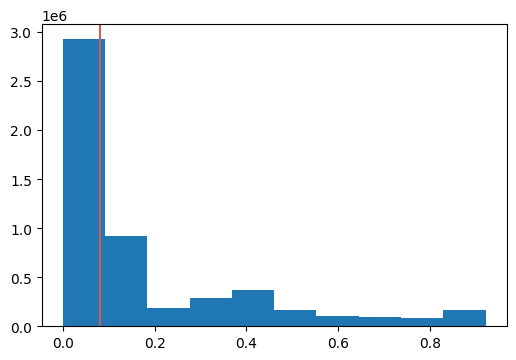

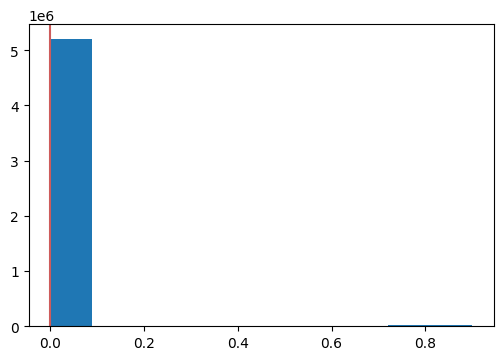

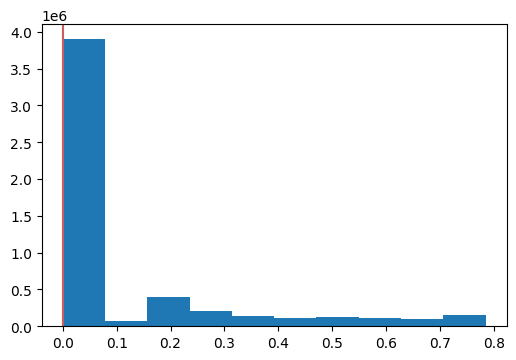

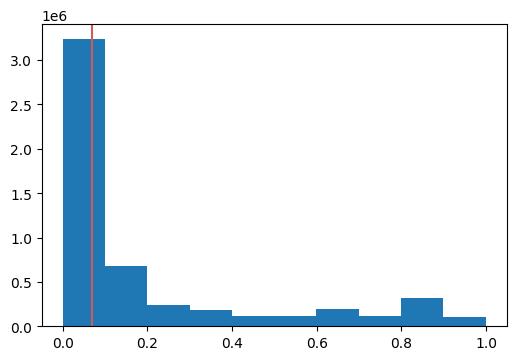

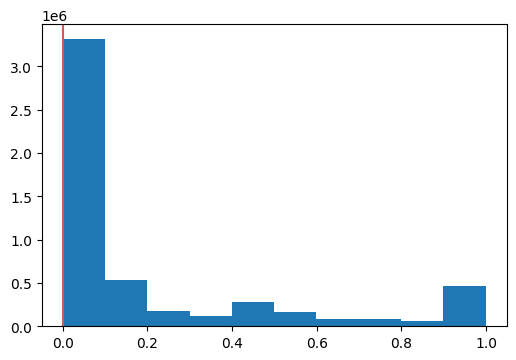

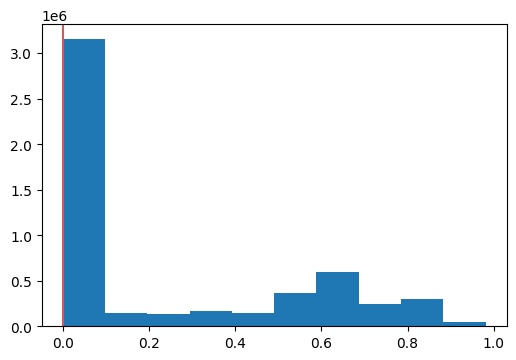

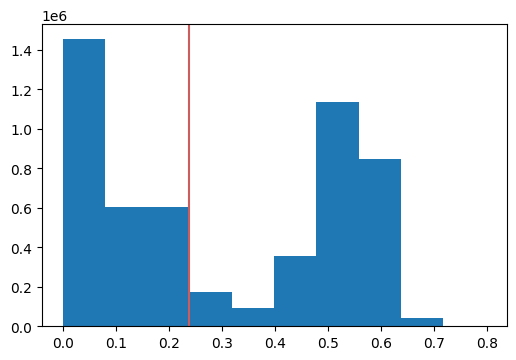

In [3]:
# inspect distribution of edge features

amount = 1000

count = 0
edge_feats = list()
for ego in train_loader:
    count += 1
    edge_feats.append(ego.edge_attr.numpy())
    if count >= amount:
        break
edge_feats = np.vstack(edge_feats)

for f in range(7):
    plt.figure(dpi=100)
    plt.hist(edge_feats[:,f], log=False)
    plt.axvline(x=np.median(edge_feats[:,f]), color='indianred')
    plt.show()
    plt.close()

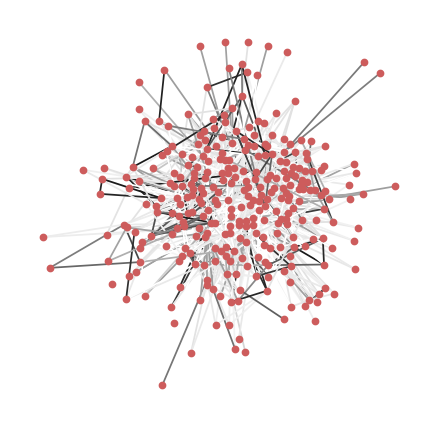

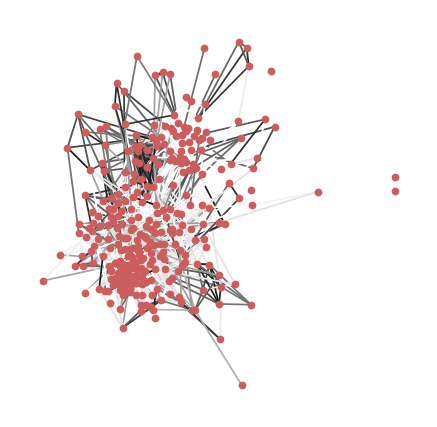

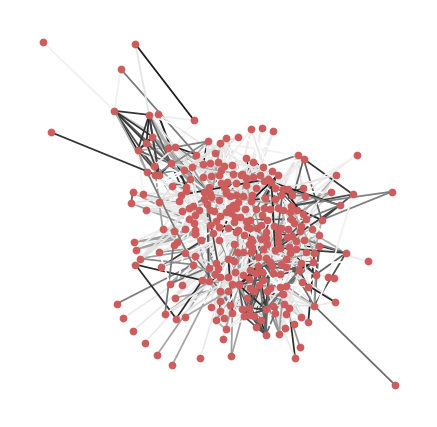

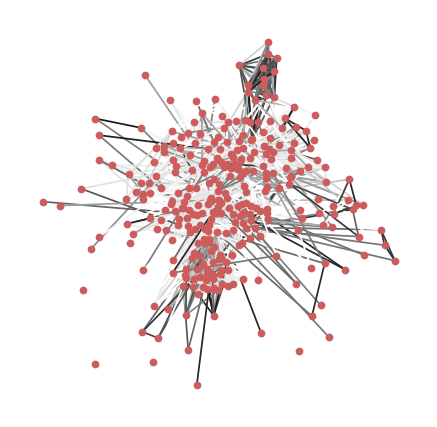

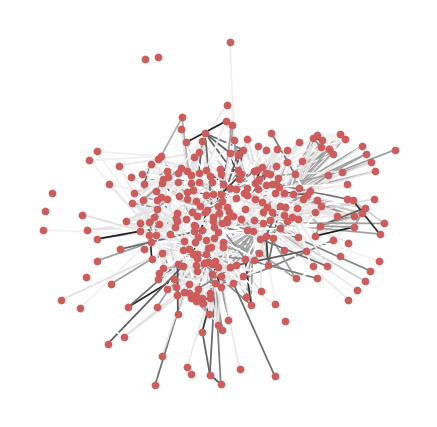

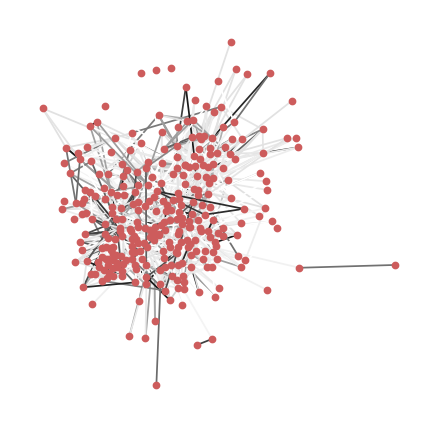

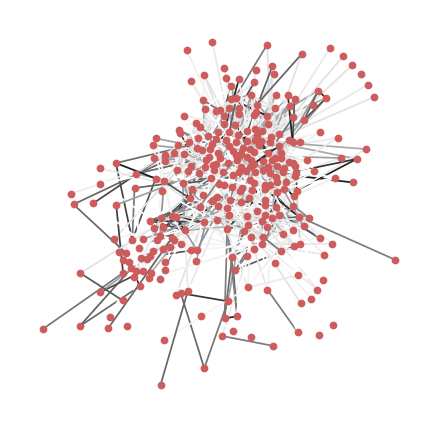

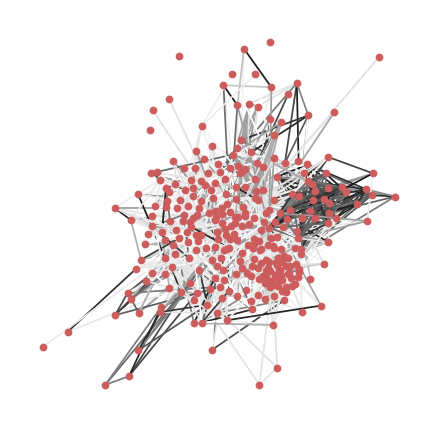

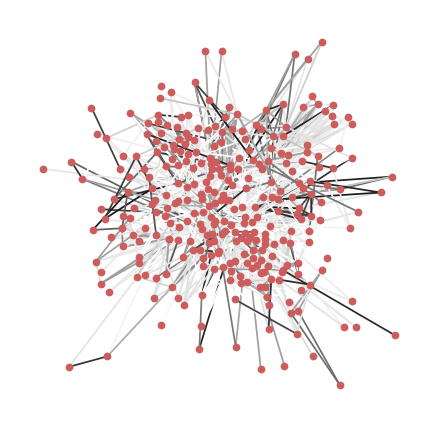

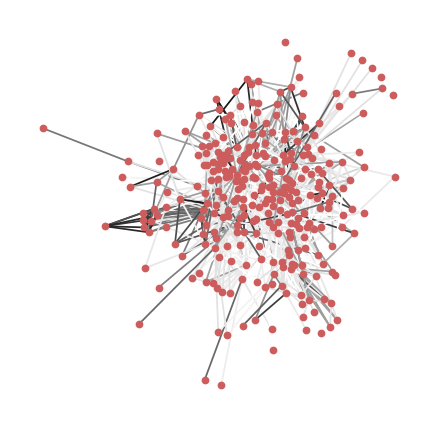

In [4]:
# visualize some egos

amount = 10

count = 0
for ego in train_loader:
    count += 1
    draw_ppa_ego(ego, edge_feature_idx=0)
    if count >= amount:
        break

In [22]:
%%time
# let's see how the number of maximal cliques changes w.r.t. the edge threshold

t_list = [0.3, 0.5, 0.7, 0.8, 0.9]
max_clique_size = 6
sample_size = 1000

for t in t_list:
    
    train_loader = DataLoader(dataset[split_idx["train"]], batch_size=bs, shuffle=False)
    thresholds = t * np.asarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
    filt = np.any

    print('Threshold: {}'.format(t))
    H = np.zeros((sample_size, max_clique_size+1))
    count = 0
    for e, ego in enumerate(train_loader):
        edges = filter_out_edges(ego, thresholds, filt)[0]
        G = nx.from_edgelist(edges)
        for clique in nx.find_cliques(G):
            size = len(clique)
            if size > max_clique_size:
                continue
            H[e, size] += 1
        count += 1
        print('\r{}/{}    ...'.format(count, sample_size), end='')
        if count >= sample_size:
            break
    print('Number of overall (maximal) triangles: {}'.format(H[:,3].sum()))
    print('Number of egos with at least one (maximal) triangle: {} (median: {:.2f} per ego)'.format((H[:,3]>0).sum(), np.median(H[:,3])))
    print('Number of egos with at least one (maximal) 4-clique: {} (median: {:.2f} per ego)'.format((H[:,4]>0).sum(), np.median(H[:,4])))
    print('Number of egos with at least one (maximal) 5-clique: {} (median: {:.2f} per ego)'.format((H[:,5]>0).sum(), np.median(H[:,5])))
    print('Number of egos with at least one (maximal) 6-clique: {} (median: {:.2f} per ego)'.format((H[:,6]>0).sum(), np.median(H[:,6])))
    print('Number of overall egos: {}'.format(H.shape[0]))
    print('-------------------------------------------------')

Threshold: 0.3
93/1000    ...

KeyboardInterrupt: 

In [5]:
import pickle
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=bs, shuffle=False)
hot = 10
for e, ego in enumerate(train_loader):
    if e < hot:
        continue
    else:
        with open('ego.pickle', 'wb') as handle:
            pickle.dump(ego, handle)
        break

In [6]:
%load_ext autoreload
%autoreload 2

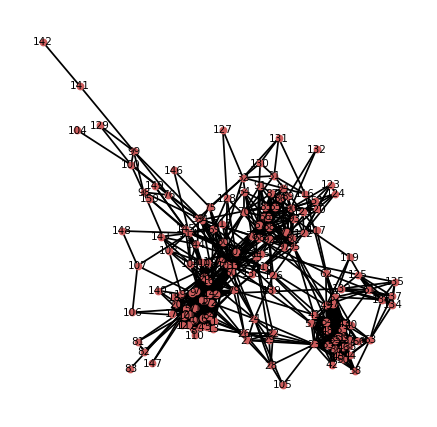

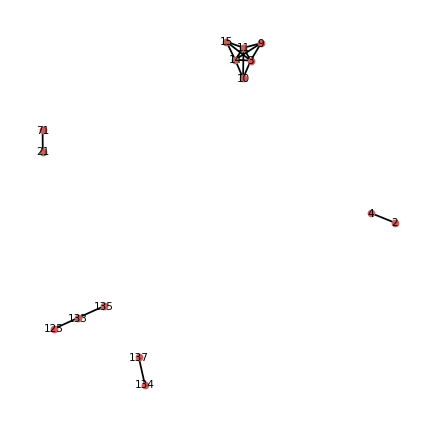

[[  3   9]
 [  9   3]
 [  3  14]
 [ 14   3]
 [  3  11]
 [ 11   3]
 [  3  10]
 [ 10   3]
 [  3  15]
 [ 15   3]
 [ 71  21]
 [ 21  71]
 [133 135]
 [135 133]
 [133 125]
 [125 133]
 [ 10  11]
 [ 11  10]
 [ 10  14]
 [ 14  10]
 [ 15  14]
 [ 14  15]
 [ 15  11]
 [ 11  15]
 [137 134]
 [134 137]
 [ 14  11]
 [ 11  14]
 [ 14   9]
 [  9  14]
 [  2   4]
 [  4   2]
 [  9  11]
 [ 11   9]]


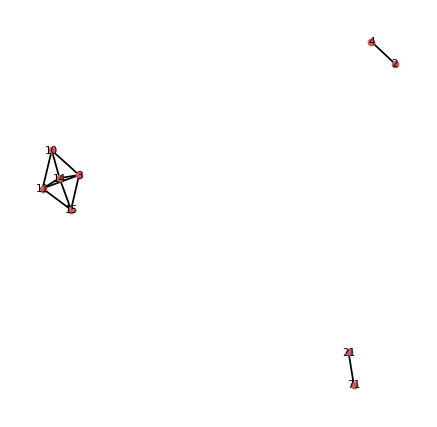

[[ 3 14]
 [14  3]
 [ 3 11]
 [11  3]
 [ 3 10]
 [10  3]
 [ 3 15]
 [15  3]
 [71 21]
 [21 71]
 [10 11]
 [11 10]
 [10 14]
 [14 10]
 [15 14]
 [14 15]
 [15 11]
 [11 15]
 [14 11]
 [11 14]
 [ 2  4]
 [ 4  2]]


In [7]:
edge_th = 0.95
clique_th = 0.98

edges, _ = filter_out_edges(ego, 0.0*np.asarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]), np.any)
draw_ppa_ego(edges, from_edge_list=True, with_labels=True)
filtered_edges, kept_edges = filter_out_edges(ego, edge_th*np.asarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]), np.any)
draw_ppa_ego(filtered_edges, with_labels=True, from_edge_list=True)
print(filtered_edges)
filtered_edges_for_cliques, _ = filter_out_edges(ego, clique_th*np.asarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]), np.any)
draw_ppa_ego(filtered_edges_for_cliques, with_labels=True, from_edge_list=True)
print(filtered_edges_for_cliques)

In [21]:
%%time
complex, upper_adjacencies, lower_adjacencies = extract_complex(ego, edge_th, clique_th, 3, keep_isolated_nodes=False)

CPU times: user 2.67 ms, sys: 0 ns, total: 2.67 ms
Wall time: 2.34 ms


In [18]:
upper_adjacencies

{1: {(2,): {(4,)},
  (4,): {(2,)},
  (71,): {(21,)},
  (21,): {(71,)},
  (3,): {(9,), (10,), (11,), (14,), (15,)},
  (9,): {(3,), (11,), (14,)},
  (135,): {(133,)},
  (133,): {(125,), (135,)},
  (125,): {(133,)},
  (137,): {(134,)},
  (134,): {(137,)},
  (14,): {(3,), (9,), (10,), (11,), (15,)},
  (11,): {(3,), (9,), (10,), (14,), (15,)},
  (10,): {(3,), (11,), (14,)},
  (15,): {(3,), (11,), (14,)}},
 2: {(10, 11): {(3, 10), (3, 11), (10, 14), (11, 14)},
  (3, 10): {(3, 11), (3, 14), (10, 11), (10, 14)},
  (3, 11): {(3, 10), (3, 14), (3, 15), (10, 11), (11, 14), (11, 15)},
  (3, 14): {(3, 10), (3, 11), (3, 15), (10, 14), (11, 14), (14, 15)},
  (10, 14): {(3, 10), (3, 14), (10, 11), (11, 14)},
  (11, 14): {(3, 11), (3, 14), (10, 11), (10, 14), (11, 15), (14, 15)},
  (11, 15): {(3, 11), (3, 15), (11, 14), (14, 15)},
  (3, 15): {(3, 11), (3, 14), (11, 15), (14, 15)},
  (14, 15): {(3, 14), (3, 15), (11, 14), (11, 15)}}}

In [20]:
lower_adjacencies

{2: {(133, 135): {(125, 133)},
  (125, 133): {(133, 135)},
  (3, 10): {(3, 9), (3, 11), (3, 14), (3, 15), (10, 11), (10, 14)},
  (3, 9): {(3, 10), (3, 11), (3, 14), (3, 15), (9, 11), (9, 14)},
  (3, 15): {(3, 9), (3, 10), (3, 11), (3, 14), (11, 15), (14, 15)},
  (10, 11): {(3, 10), (3, 11), (9, 11), (10, 14), (11, 14), (11, 15)},
  (10, 14): {(3, 10), (3, 14), (9, 14), (10, 11), (11, 14), (14, 15)},
  (3, 11): {(3, 9),
   (3, 10),
   (3, 14),
   (3, 15),
   (9, 11),
   (10, 11),
   (11, 14),
   (11, 15)},
  (3, 14): {(3, 9),
   (3, 10),
   (3, 11),
   (3, 15),
   (9, 14),
   (10, 14),
   (11, 14),
   (14, 15)},
  (9, 14): {(3, 9), (3, 14), (9, 11), (10, 14), (11, 14), (14, 15)},
  (9, 11): {(3, 9), (3, 11), (9, 14), (10, 11), (11, 14), (11, 15)},
  (11, 14): {(3, 11),
   (3, 14),
   (9, 11),
   (9, 14),
   (10, 11),
   (10, 14),
   (11, 15),
   (14, 15)},
  (14, 15): {(3, 14), (3, 15), (9, 14), (10, 14), (11, 14), (11, 15)},
  (11, 15): {(3, 11), (3, 15), (9, 11), (10, 11), (11, 14), (

In [ ]:
amount = 1000
edge_th = 0.7
clique_th = 0.7

train_loader = DataLoader(dataset[split_idx["train"]], batch_size=bs, shuffle=False)
count = 0
already_computed = 0
if already_computed == 0:
    train_complexes = list()
for ego in train_loader:
    if count <= already_computed:
        count += 1
        print('\rtrain: {} ...    '.format(count), end='')
        continue
    complex, _, _ = extract_complex(ego, edge_th, clique_th, 3, keep_isolated_nodes=False)
    train_complexes.append(complex)
    count += 1
    print('\rtrain: {} ...    '.format(count), end='')
    if count >= amount:
        break

train: 948 ...    

In [ ]:
already_computed = len(train_complexes)

In [ ]:
amount = 200
val_loader = DataLoader(dataset[split_idx["valid"]], batch_size=bs, shuffle=False)
count = 0
val_complexes = list()
for ego in val_loader:
    complex, _, _ = extract_complex(ego, edge_th, clique_th, 3, keep_isolated_nodes=False)
    val_complexes.append(complex)
    count += 1
    print('\rvalidation: {} ...    '.format(count), end='')
    if count >= amount:
        break

test_loader = DataLoader(dataset[split_idx["test"]], batch_size=bs, shuffle=False)
count = 0
test_complexes = list()
for ego in test_loader:
    complex, _, _ = extract_complex(ego, edge_th, clique_th, 3, keep_isolated_nodes=False)
    test_complexes.append(complex)
    count += 1
    print('\rtest: {} ...    '.format(count), end='')
    if count >= amount:
        break

In [ ]:
with open('dataset_{}_{}_{}_{}_iso_{}.pickle'.format(edge_th, clique_th, amount, 3, False), 'wb') as handle:
    pickle.dump((train_complexes, val_complexes, test_complexes), handle)